## Dự đoán chất lượng không khí bằng LSTM
Tập trung vào chỉ số PM2.5 từ OpenAQ để xây dựng mô hình LSTM đơn biến dự báo từng giờ.

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
import joblib

sns.set(style='whitegrid')
np.random.seed(42)
keras.utils.set_random_seed(42)
plt.rcParams['figure.figsize'] = (10, 4)


In [38]:
data_path = 'full.csv'
# Chỉ lấy các cột cần thiết để tiết kiệm bộ nhớ
# Thêm encoding phù hợp để tránh lỗi decode từ dữ liệu OpenAQ
df = pd.read_csv(
    data_path,
    usecols=['parameter', 'value', 'datetimeLocal'],
    parse_dates=['datetimeLocal'],
    encoding='latin1',
    on_bad_lines='skip'
)
print('Loaded', len(df), 'rows with columns', df.columns.tolist())


Loaded 17239 rows with columns ['parameter', 'value', 'datetimeLocal']


In [39]:
# Lọc ra PM2.5 và chuẩn hóa lại thành chuỗi thời gian đều đặn từng giờ
pm25 = (
    df[df['parameter'] == 'pm25']
    .dropna(subset=['value', 'datetimeLocal'])
    .assign(value=lambda d: d['value'].astype(float))
    .set_index('datetimeLocal')
    .sort_index()
)
pm25 = pm25['value'].resample('1H').mean().interpolate()
print('After resampling we have', len(pm25), 'hourly PM2.5 records')
print('Last 5 measurements:', pm25.tail())


After resampling we have 336 hourly PM2.5 records
Last 5 measurements: datetimeLocal
2025-12-15 03:00:00+07:00    57.133542
2025-12-15 04:00:00+07:00    47.899417
2025-12-15 05:00:00+07:00    45.011979
2025-12-15 06:00:00+07:00    36.409833
2025-12-15 07:00:00+07:00    40.650000
Freq: h, Name: value, dtype: float64


C:\Users\Aspire 7\AppData\Local\Temp\ipykernel_22376\3930993842.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pm25 = pm25['value'].resample('1H').mean().interpolate()


In [40]:
def make_sequences(values, window):
    xs, ys = [], []
    for start in range(len(values) - window):
        xs.append(values[start : start + window])
        ys.append(values[start + window])
    return np.array(xs), np.array(ys)

window_size = 24  # dùng 24 giờ trước để dự đoán giờ tiếp theo
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(pm25.values.reshape(-1, 1))
X, y = make_sequences(scaled_values, window_size)
print('Prepared', X.shape[0], 'sequences of length', window_size)


Prepared 312 sequences of length 24


In [41]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
print(f'Train sequences: {len(X_train)}, Test sequences: {len(X_test)}')


Train sequences: 249, Test sequences: 63


In [42]:
# Xây dựng mô hình sâu kết hợp CNN + LSTM và in chi tiết cấu trúc
model = keras.Sequential([
    keras.layers.Input(shape=(window_size, 1)),
    keras.layers.Conv1D(32, kernel_size=3, padding='causal', activation='gelu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
    keras.layers.Dropout(0.3),
    keras.layers.Bidirectional(keras.layers.LSTM(48, return_sequences=True)),
    keras.layers.LayerNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(32),
    keras.layers.Dense(32, activation='swish'),
    keras.layers.Dense(1),
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1,
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 12, 128)        │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 12, 96)         │        67,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 12, 96)         │           192 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,553 (529.50 KB)

 Trainable params: 135,553 (529.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - loss: 0.0640 - mae: 0.2037 - val_loss: 0.0573 - val_mae: 0.2157
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0268 - mae: 0.1317 - val_loss: 0.0522 - val_mae: 0.1948
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0265 - mae: 0.1283 - val_loss: 0.0484 - val_mae: 0.1900
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0202 - mae: 0.1121 - val_loss: 0.0367 - val_mae: 0.1574
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0196 - mae: 0.1106 - val_loss: 0.0321 - val_mae: 0.1440
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0186 - mae: 0.1071 - val_loss: 0.0305 - val_mae: 0.1362
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0159 - mae: 0.0998 - val_loss: 0.0269 - val_mae: 0.1271
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0156 - mae: 0.0983 - val_loss: 0.0251 - val_mae: 0.1234
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0144 - mae: 0.0951 -

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step  
Test MAE: 14.52 µg/m³, RMSE: 18.41 µg/m³


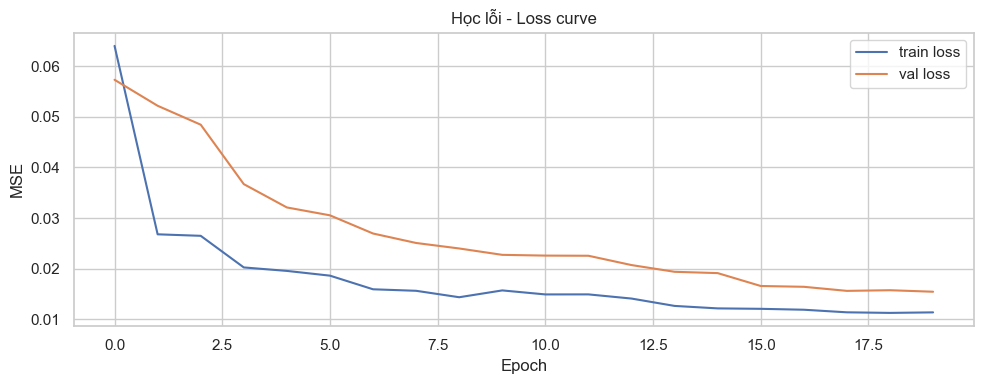

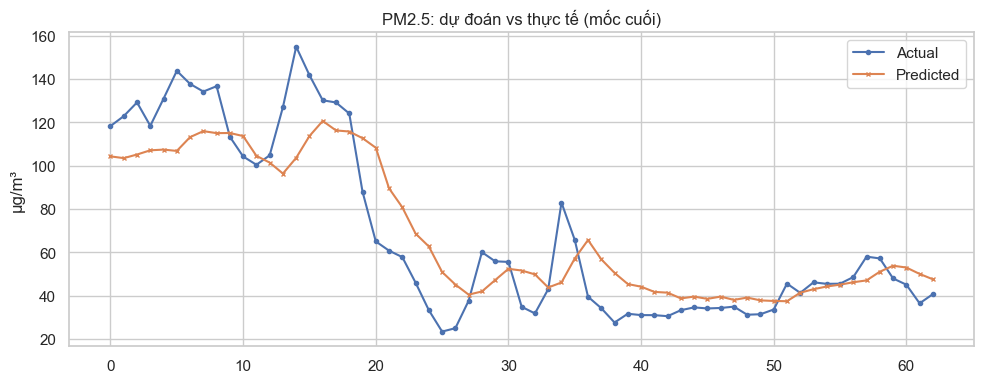

In [43]:
# Đánh giá mô hình và vẽ biểu đồ
predictions = model.predict(X_test)
pred_values = scaler.inverse_transform(predictions).flatten()
actual_values = scaler.inverse_transform(y_test).flatten()
mae = mean_absolute_error(actual_values, pred_values)
mse = mean_squared_error(actual_values, pred_values)
rmse = np.sqrt(mse)
print(f'Test MAE: {mae:.2f} µg/m³, RMSE: {rmse:.2f} µg/m³')

plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Học lỗi - Loss curve')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.show()

slice_start = max(0, len(actual_values) - 120)
plt.figure()
plt.plot(actual_values[slice_start:], label='Actual', marker='o', markersize=3)
plt.plot(pred_values[slice_start:], label='Predicted', marker='x', markersize=3)
plt.title('PM2.5: dự đoán vs thực tế (mốc cuối)')
plt.ylabel('µg/m³')
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
artifact_dir = 'case10-chat-luong-kk/models'
os.makedirs(artifact_dir, exist_ok=True)
model_path = os.path.join(artifact_dir, 'pm25_lstm.h5')
keras_format_path = os.path.join(artifact_dir, 'pm25_lstm.keras')
scaler_path = os.path.join(artifact_dir, 'pm25_scaler.pkl')
model.save(model_path)
model.save(keras_format_path)
joblib.dump(scaler, scaler_path)
print('Saved LSTM model to', model_path)
print('Saved LSTM model to', keras_format_path)
print('Saved scaler to', scaler_path)


Saved LSTM model to case10-chat-luong-kk/models\pm25_lstm.h5
Saved LSTM model to case10-chat-luong-kk/models\pm25_lstm.keras
Saved scaler to case10-chat-luong-kk/models\pm25_scaler.pkl


### Diễn giải kết quả
- Mô hình học từ 24 giờ trước để dự đoán giá trị PM2.5 tiếp theo với sai số MAE và RMSE thể hiện độ ổn định của dự báo.
- Biểu đồ loss chứng minh mô hình giữ được độ hội tụ ổn định, và biểu đồ cuối cùng so sánh giá trị dự đoán với quan sát thực tế trong các giờ gần nhất.

### Triển khai cục bộ
- Tải `case10-chat-luong-kk/models/pm25_lstm.h5`, `pm25_lstm.keras` và `pm25_scaler.pkl` vào môi trường deploy.
- Sử dụng cùng window 24 giờ, chuẩn hóa dữ liệu mới với scaler lưu sẵn rồi gọi `keras.models.load_model` (đối với `.keras`) hoặc `keras.models.load_model(..., compile=False)` rồi đo lại nếu cần để lấy dự đoán.
